In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import cebra
from PIL import Image
import cv2
import os
import torch
import itertools
import random
import gc
import pandas as pd
import re
import ast
import tifffile

In [2]:
mask_df = pd.read_csv('/mnt/teams/TM_Lab/Tony/water_reaching/Data/rig1_data/processed/FRM1_2023-07-07_1/mask.csv')
#read gcamp raw file
tif_path = '/mnt/teams/TM_Lab/Tony/water_reaching/Data/rig1_data/processed/FRM1_2023-07-07_1/trial_0/brain/gcamp_raw.tif'
gcamp_raw = tifffile.imread(tif_path)

In [4]:
display(mask_df)

,Unnamed: 0,acronym,name,reference,resolution,label,allen_id,allen_rgb,left_center,right_center,left_x,left_y,right_x,right_y
0,0,MOB,Main olfactory bulb,"[540, 570]",10,"{'acronym': 'MOB', 'rgb_triplet': [154, 210, 1...",507,"[154, 210, 189]","(68.56429531567537, 76.08483523418984)","(118.74483195140753, 75.7169690536079)","[85.93987231518959, 85.82443274678903, 85.7089...","[93.74011432557356, 93.6167715811166, 93.49337...","[100.06012768481035, 100.17556725321091, 100.2...","[93.74011432557356, 93.61677158111658, 93.4933..."
1,1,FRP,"Frontal pole, cerebral cortex","[540, 570]",10,"{'acronym': 'FRP', 'rgb_triplet': [38, 143, 69...",184,"[38, 143, 69]","(70.73862016560471, 95.25182009758237)","(115.26137983439527, 95.2518200975824)","[77.37421757102894, 77.14775695611633, 76.9212...","[96.92822913209177, 96.92822913209177, 96.9282...","[108.625782428971, 108.85224304388363, 109.078...","[96.92822913209176, 96.92822913209176, 96.9282..."
2,2,MOp,Primary motor area,"[540, 570]",10,"{'acronym': 'MOp', 'rgb_triplet': [31, 157, 90...",985,"[31, 157, 90]","(51.694757359996785, 150.90895601421155)","(136.02141112705294, 149.3749383901012)","[78.78470459034304, 78.59260600372605, 78.4005...","[182.15207407949973, 182.15207407949973, 182.1...","[107.21529540965703, 107.40739399627402, 107.5...","[182.15207407949973, 182.15207407949973, 182.1..."
3,3,MOs,Secondary motor area,"[540, 570]",10,"{'acronym': 'MOs', 'rgb_triplet': [31, 157, 90...",993,"[31, 157, 90]","(65.51344093659554, 127.31232405491173)","(120.97500588753739, 127.09398343308143)","[85.89235229517155, 85.70025370855456, 85.5081...","[182.15207407949973, 182.15207407949973, 182.1...","[100.10764770482854, 100.29974629144553, 100.4...","[182.15207407949973, 182.15207407949973, 182.1..."
4,4,SSp-n,"Primary somatosensory area, nose","[540, 570]",10,"{'acronym': 'SSp-n', 'rgb_triplet': [24, 128, ...",353,"[24, 128, 100]","(20.001365688030187, 170.55948829265262)","(168.3525670918734, 171.05672902691606)","[18.32188194373191, 18.52209137551814, 18.6079...","[162.0357583268345, 162.0357583268345, 161.940...","[171.93124105753944, 171.73141513081146, 171.6...","[162.98691800062963, 162.98691800062963, 162.8..."
5,5,SSp-m,"Primary somatosensory area, mouth","[540, 570]",10,"{'acronym': 'SSp-m', 'rgb_triplet': [24, 128, ...",345,"[24, 128, 100]","(24.871823090419007, 153.43432470578193)","(163.11758170120945, 152.57640509782462)","[24.9272713449323, 25.045098913340173, 25.1628...","[141.49285072678032, 141.59617686993303, 141.6...","[164.24334078718172, 164.03380154957236, 163.9...","[138.89620678413328, 138.8962067841333, 139.00..."
6,6,SSp-un,"Primary somatosensory area, unassigned","[540, 570]",10,"{'acronym': 'SSp-un', 'rgb_triplet': [24, 128,...",182305689,"[24, 128, 100]","(33.03881626291057, 174.97120696469113)","(152.96118373708939, 174.9712069646909)","[41.29636008468485, 41.10834684862916, 41.0049...","[192.28445857659835, 192.28445857659835, 192.2...","[144.70363991531536, 144.89165315137103, 144.9...","[192.2844585765985, 192.2844585765985, 192.200..."
7,7,PL,Prelimbic area,"[540, 570]",10,"{'acronym': 'PL', 'rgb_triplet': [47, 168, 80]...",972,"[47, 168, 80]","(82.44955947327045, 100.48528195176193)","(103.55044052672943, 100.48528195176202)","[85.91325572797405, 85.80099706544533, 85.6886...","[109.3287482147733, 109.21212021345166, 109.09...","[100.0867442720259, 100.19900293455464, 100.31...","[109.3287482147733, 109.21212021345164, 109.09..."
8,8,ACAd,"Anterior cingulate area, dorsal part","[540, 570]",10,"{'acronym': 'ACAd', 'rgb_triplet': [64, 166, 1...",39,"[64, 166, 102]","(None, None)","(None, None)",[],[],[],[]
9,9,RSPv,"Retrosplenial area, ventral part","[540, 570]",10,"{'acronym': 'RSPv', 'rgb_triplet': [26, 166, 1...",886,"[26, 166, 152]","(None, None)","(None, None)",[],[],[],[]


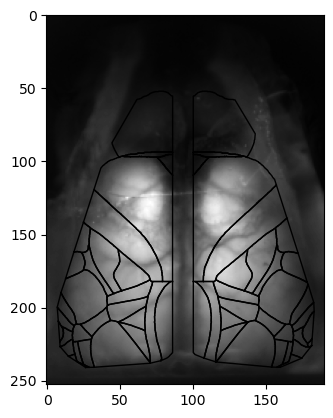

In [5]:
## Plot all on top of eachother
for index, row in mask_df.iterrows():
    right_x_coords = ast.literal_eval(row['right_x'])
    right_y_coords = ast.literal_eval(row['right_y'])
    left_x_coords = ast.literal_eval(row['left_x'])
    left_y_coords = ast.literal_eval(row['left_y'])
    left_center = ast.literal_eval(row['left_center'])
    plt.plot(left_x_coords,left_y_coords,color='black',  linewidth=1)
    plt.plot(right_x_coords, right_y_coords, color='black', linewidth=1)


plt.imshow(gcamp_raw[0,:,:], cmap='gray')
plt.show()

In [6]:
masks = []
for index, row in mask_df.iterrows():
    mask_right = np.zeros_like(gcamp_raw[0,:,:])
    mask_left = np.zeros_like(gcamp_raw[0,:,:])
    right_x_coords = ast.literal_eval(row['right_x'])
    right_y_coords = ast.literal_eval(row['right_y'])
    left_x_coords = ast.literal_eval(row['left_x'])
    left_y_coords = ast.literal_eval(row['left_y'])
    left_center = ast.literal_eval(row['left_center'])
    right_pts = np.array([right_x_coords, right_y_coords]).T
    left_pts = np.array([left_x_coords, left_y_coords]).T
    ## Check if left or right is empty
    if len(right_x_coords) > 0:
        cv2.fillPoly(mask_right, np.int32([right_pts]), 1)
        masks.append(mask_right)
    if len(left_x_coords) > 0:
        cv2.fillPoly(mask_left, np.int32([left_pts]), 1)
        masks.append(mask_left)
masks = np.array(masks)

In [ ]:
def load_masks(path, min_size=50):
    mask_df = pd.read_csv(path)
    masks = []
    masks = []
    for index, row in mask_df.iterrows():
        mask_right = np.zeros_like(gcamp_raw[0,:,:])
        mask_left = np.zeros_like(gcamp_raw[0,:,:])
        right_x_coords = ast.literal_eval(row['right_x'])
        right_y_coords = ast.literal_eval(row['right_y'])
        left_x_coords = ast.literal_eval(row['left_x'])
        left_y_coords = ast.literal_eval(row['left_y'])
        left_center = ast.literal_eval(row['left_center'])
        right_pts = np.array([right_x_coords, right_y_coords]).T
        left_pts = np.array([left_x_coords, left_y_coords]).T
        ## Check if left or right is empty
        if len(right_x_coords) > 0:
            cv2.fillPoly(mask_right, np.int32([right_pts]), 1)
            masks.append(mask_right)
        if len(left_x_coords) > 0:
            cv2.fillPoly(mask_left, np.int32([left_pts]), 1)
            masks.append(mask_left)
    masks_filtered = np.array([ mask for mask in masks if np.sum(mask) > min_size])

(253, 190)


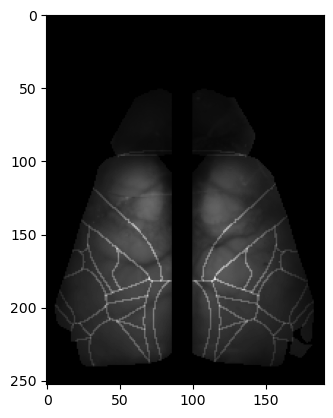

In [15]:
## Filter all masks with an area below a set threshold
masks_filtered = np.array([ mask for mask in masks if np.sum(mask) > 100])

plt.imshow(np.sum(masks_filtered, axis=0) * gcamp_raw[0, :, :], cmap='gray')
print(np.zeros((253, 190)).shape)

In [14]:
torch_masks = torch.from_numpy(masks_filtered).float()
torch_gcamp = torch.from_numpy(gcamp_raw).float()

masked_tensor = torch_masks.unsqueeze(0) * torch_gcamp.unsqueeze(1)
batch_size, num_masks, height, width = masked_tensor.shape


torch.Size([6969888])

In [7]:
## Defines a layer which applies the mask tensor and then reduces with a linear layer
# masks: n_masks x h x w
# n_features: number of features to reduce to
class masked_reduction_layer(torch.nn.Module):
    def __init__(self, masks, n_features, top_k=None):
        super(masked_reduction_layer, self).__init__()
        shape = masks.shape
        if top_k is None:
            self.lin_shape = shape[1] * shape[2]
        else:
            self.lin_shape = top_k
        ## make masks a parameter so that it can be trained
        self.masks = masks.unsqueeze(0).detach()
        self.top_k = top_k
        # create 1 linear layer for each mask
        self.linear_layers = torch.nn.ModuleList([torch.nn.Linear(self.lin_shape, n_features) for i in range(shape[0])])
    # x: n x h x w
    def forward(self, x):
        ## softmax over masks
        x = x.unsqueeze(1) * self.masks
        x = x.flatten(start_dim=2)
        ## take only the top 1500 pixels
        if self.top_k is not None:
            x = torch.topk(x, self.top_k, dim=2)[0]
        x = torch.stack([self.linear_layers[i](x[:,i,:]) for i in range(x.shape[1])], dim=1)
        return x.to_sparse()
    
    def get_masks(self):
        return self.masks.detach().cpu().numpy()
    
from x_transformers import Encoder

class MaskedTransformer(torch.nn.Module):
    def __init__(self, num_units, num_output, masks):
        super(MaskedTransformer, self).__init__()
        self.reduce_layer = masked_reduction_layer(masks, num_units)
        self.cls_token = torch.nn.Parameter(torch.randn(1, 1, num_units))
        self.net = Encoder(
                dim = num_units,                  # set to be the same as the wrapper
                depth = 6,
                heads = 4,
                ff_glu = True,              # ex. feed forward GLU variant https://arxiv.org/abs/2002.05202
                residual_attn = True        # ex. residual attention https://arxiv.org/abs/2012.11747
        )
        self.linear_out = torch.nn.Linear(num_units, num_output)

    def get_offset(self):
        return cebra.data.Offset(0, 1)
    def forward(self, x):
        x = self.reduce_layer(x)
        ## Add cls token
        cls_tokens = self.cls_token.repeat(x.shape[0], 1, 1)
        x = torch.cat((cls_tokens, x), dim=1)
        x = self.net(x)
        x = self.linear_out(x[:,0,:])
        return x
    def get_masks(self):
        return self.reduce_layer.get_masks()

In [30]:

## Multi Session Data Loading


## Given the path to a tif file, return that as a 3d numpy array
# @param path: path to tif file
# @return: 3d numpy array, first array is time dimension
def load_tif(path):
    img = cv2.imreadmulti(path, flags=(cv2.IMREAD_GRAYSCALE | cv2.IMREAD_ANYDEPTH))[1]
    img = np.array(img)
    return img

## Loads the brain data from a given trial
def load_brain_data(parent_directory, trial_num, type='gcamp'):
    # Load the data
    data_path = os.path.join(parent_directory, 'trial_' + str(trial_num) + '/brain/' + type + '.tif')
    data = load_tif(data_path)
    return data

def load_pose_data(parent_directory, trial_num):
    # Load the data
    data_path = os.path.join(parent_directory, 'trial_' + str(trial_num) + '/anipose/videos/pose-3d/vid.csv')
    data = pd.read_csv(data_path)
    data = data.to_numpy()
    return data

## Load image embeddings from .npy files
def load_embedding_data(parent_directory, trial_num):
    # Load the data
    data_path = os.path.join(parent_directory, 'trial_' + str(trial_num) + '_embeddings.npy')
    data = np.load(data_path)
    return data

## From a given path load and then flatten the trial and brain data and do a test / train split
# @param data_path: path to the data
# @param split: the percentage of data to be used for training
# @return: flattened brain data, flattened feature data, discrete training data, testing brain data, testing feature data
def load_test_train(data_path, split, use_pose=False, embedding_path=None):
    num_trials = len([x for x in os.listdir(data_path) if re.match('trial_[0-9]+$', x)])
    brain_data = [load_brain_data(data_path, x) for x in range(num_trials)]
    if use_pose == True:
        feature_data = [load_pose_data(data_path, x) for x in range(len(brain_data))]
    else:
        feature_data = [load_embedding_data(embedding_path, x) for x in range(len(brain_data))]
    # flatten the first dimension of brain data
    # n x 288 x 256 x 256 -> n * 288 x 256 x 256
    # before flattening take train test split
    training_brain_data = brain_data[:int(len(brain_data) * split)]
    testing_brain_data = brain_data[int(len(brain_data) * split):]
    flattened_brain_data = np.concatenate(training_brain_data, axis=0)
    training_feature_data = feature_data[:int(len(feature_data) * split)]
    testing_feature_data = feature_data[int(len(feature_data) * split):]
    flattened_feature_data = np.concatenate(training_feature_data, axis=0)
    # create a discrete tensor for the brain data of 0-288 repeating
    discrete_training_data = np.concatenate(np.array([np.arange(288) for _ in range(len(training_brain_data))]), axis=0)
    return flattened_brain_data, flattened_feature_data, discrete_training_data, testing_brain_data, testing_feature_data

## Load Train data on multiple trials and concatenate them
# @param data_paths: list of paths to the data
# @param split: the percentage of data to be used for training
# @return: flattened brain data, flattened feature data, discrete training data, testing brain data, testing feature data
def load_train_data_multi(data_paths, split, use_pose=False, embedding_paths=None):
    for i, data_path in enumerate(data_paths):
        flattened_brain_data, flattened_feature_data, discrete_training_data, _, _ = load_test_train(data_path, split, use_pose, embedding_paths[i])
        if i == 0:
            brain_data = flattened_brain_data
            feature_data = flattened_feature_data
            discrete_data = discrete_training_data
        else:
            brain_data = np.concatenate((brain_data, flattened_brain_data), axis=0)
            feature_data = np.concatenate((feature_data, flattened_feature_data), axis=0)
            discrete_data = np.concatenate((discrete_data, discrete_training_data), axis=0)
    return brain_data, feature_data, discrete_data, None, None

data_paths = [
    '/mnt/teams/TM_Lab/Tony/water_reaching/Data/rig1_data/processed/FRM1_2023-07-07_1',
]

embedding_paths = [
    '/home/murph_4090ws/Documents/Water_Reaching_Classifier/FRM1_7-07',
]

print('Loading data')
flattened_brain_data, flattened_feature_data, discrete_data, _, _ = load_train_data_multi(data_paths, 1, use_pose=False, embedding_paths=embedding_paths)

Loading data


In [32]:
brain_data=torch.from_numpy(flattened_brain_data)

## Load success Failure data from csv 
outcome_path = '/mnt/teams/TM_Lab/Tony/water_reaching/Data/rig1_data/outcomes/FRM1_2023-07-07_1.csv'
outcome_data = pd.read_csv(outcome_path)

## if outcome contains 's' append one to success array  else append 0 to success array
outcomes = outcome_data['Outcome']
# repkace all nan with None
outcomes = [x if x is not np.nan else None for x in outcomes]
success = []
for outcome in outcomes:
    if outcome is not None:
        outcome_split = outcome[1:-1].split(',')
        if 'ws' in outcome_split:
            success.extend(np.tile([1, 0], [288, 1]))
        else:
            success.extend(np.tile([0, 1], [288, 1]))
    else:
        success.extend(np.tile([0, 1], [288, 1]))

In [10]:
success_data = torch.from_numpy(np.array(success))
## convert success data to floats
success_data = success_data.type(torch.FloatTensor)

In [11]:
## Create a torch dataloader for the data

def create_dataloader(brain_data, success_data, batch_size):
    dataset = torch.utils.data.TensorDataset(brain_data, success_data)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=4)
    return dataloader

dataloader = create_dataloader(brain_data, success_data, 100)

## masks: n_masks x 256 x 190
## gcamp: 288 x 256 x 190
torch_masks = torch.from_numpy(masks_filtered).float().to('cuda')
torch_gcamp = torch.from_numpy(gcamp_raw).float().to('cuda')
model = MaskedTransformer(32, 2,torch_masks).to('cuda')
model(torch_gcamp).shape

epochs = 20
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = torch.nn.CrossEntropyLoss().to('cuda')
## training loop
loss_log = []
for epoch in range(epochs):
    for i, (brain_epoch_data, success_epoch_data) in enumerate(dataloader):
        brain_epoch_data = brain_epoch_data.to('cuda')
        success_epoch_data = success_epoch_data.to('cuda')
        optimizer.zero_grad()
        output = model(brain_epoch_data)
        loss = loss_fn(output, success_epoch_data)
        loss.backward()
        optimizer.step()
        loss_log.append(loss.item())
        if i % 10 == 0:
            print('Epoch: ', epoch, 'Batch: ', i, 'Loss: ', loss.item(), '\r', end='')

plt.plot(loss_log)



AttributeError: 'masked_reduction_layer' object has no attribute 'top_k'

## Datasets
FRM2-06-08 - prestroke
FRM2-07-* - poststroke

In [28]:
model = torch.load('/home/murph_4090ws/Documents/Water_Reaching_Classifier/Models/masked-transformer.pth')
model = model.model

In [26]:
from torch import nn
from x_transformers import Attention

def find_modules(nn_module, type):
    return [module for module in nn_module.modules() if isinstance(module, type)]

class Recorder(nn.Module):
    def __init__(self, vit, device = None):
        super().__init__()
        self.vit = vit

        self.data = None
        self.recordings = []
        self.hooks = []
        self.hook_registered = False
        self.ejected = False
        self.device = device

    def _hook(self, _, input, output):
        self.recordings.append(output[1].pre_softmax_attn.clone().detach())

    def _register_hook(self):
        modules = find_modules(self.vit, Attention)
        for module in modules:
            handle = module.attend.register_forward_hook(self._hook)
            self.hooks.append(handle)
        self.hook_registered = True

    def eject(self):
        self.ejected = True
        for hook in self.hooks:
            hook.remove()
        self.hooks.clear()
        return self.vit

    def clear(self):
        self.recordings.clear()

    def record(self, attn):
        recording = attn.clone().detach()
        self.recordings.append(recording)

    def forward(self, img):
        assert not self.ejected, 'recorder has been ejected, cannot be used anymore'
        self.clear()
        if not self.hook_registered:
            self._register_hook()

        pred = self.vit(img)

        # move all recordings to one device before stacking
        target_device = self.device if self.device is not None else img.device
        recordings = tuple(map(lambda t: t.to(target_device), self.recordings))

        attns = torch.stack(recordings, dim = 1) if len(recordings) > 0 else None
        return pred, attns

## Input is attentions maps from ViT recorder
# shape is (depth ,num_heads, num_steps, num_steps)
def rollout(attn, fusion='mean', dropout=0.0):
    # Take the mean across all heads (Subject to change)
    if fusion == 'mean':
        attn = attn.mean(dim=1)
    elif fusion == 'max':
        attn = attn.max(dim=1)[0]
    elif fusion == 'min':
        attn = attn.min(dim=1)[0]
    ## Discard lower 50% of attention
    attn[attn < torch.quantile(attn, dropout)] = 0

    # add identity adn normalize
    residual_attn = torch.eye(attn.shape[-1]).unsqueeze(0).to('cpu') + attn
    residual_attn = residual_attn / residual_attn.sum(dim=-1).unsqueeze(-1)
    # convert to numpy
    aug_attn_mat = residual_attn.detach().cpu().numpy()
    #Recursively multiply the weight matrices.
    joint_attentions = np.zeros(aug_attn_mat.shape)
    joint_attentions[0] = aug_attn_mat[0]

    for n in range(1, aug_attn_mat.shape[0]):
        joint_attentions[n] = np.matmul(aug_attn_mat[n], joint_attentions[n - 1])

    v = joint_attentions[-1]
    grid_size = int(np.sqrt(aug_attn_mat.shape[-1]))
    return v[0, 1:]

In [29]:
model = model.eval()
model_rec = Recorder(model)

In [42]:
brain_data[288 * vid_index: (288 * int(vid_index + 1))].unsqueeze(1).shape

torch.Size([288, 1, 253, 190])

In [113]:
vid_index = 12
emb, attn = model_rec(brain_data[288 * vid_index: (288 * int(vid_index + 1))].unsqueeze(1).swapdims(1, 2).to('cuda'))


In [54]:
import cebra_utils
masks = [x.get_masks() for x in model.modules() if isinstance(x, cebra_utils.masked_reduction_layer)][0]

In [84]:
attention_mapping = np.array([rollout(map.to('cpu'), fusion='max', dropout=0.6) for map in attn])
attention_map = np.sum(masks * np.expand_dims(attention_mapping, [2,3]), axis=1)
dff_video = brain_data[288 * vid_index: (288 * (vid_index + 1))].detach().cpu().numpy()

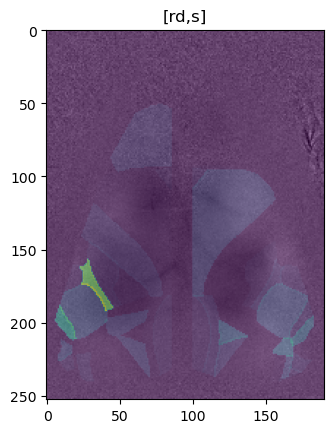

In [85]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.animation as animation
frames = [] # for storing the generated images
fig = plt.figure()
for i in range(len(attention_map)):
    frames.append([plt.imshow(attention_map[i],animated=True), plt.imshow(dff_video[i,:,:], cmap='gray', alpha=0.5, animated=True), plt.title(outcomes[vid_index])])

ani = animation.ArtistAnimation(fig, frames, interval=50, blit=True,
                                repeat_delay=1000)
ani.save('segmented_map.mp4')

plt.show()

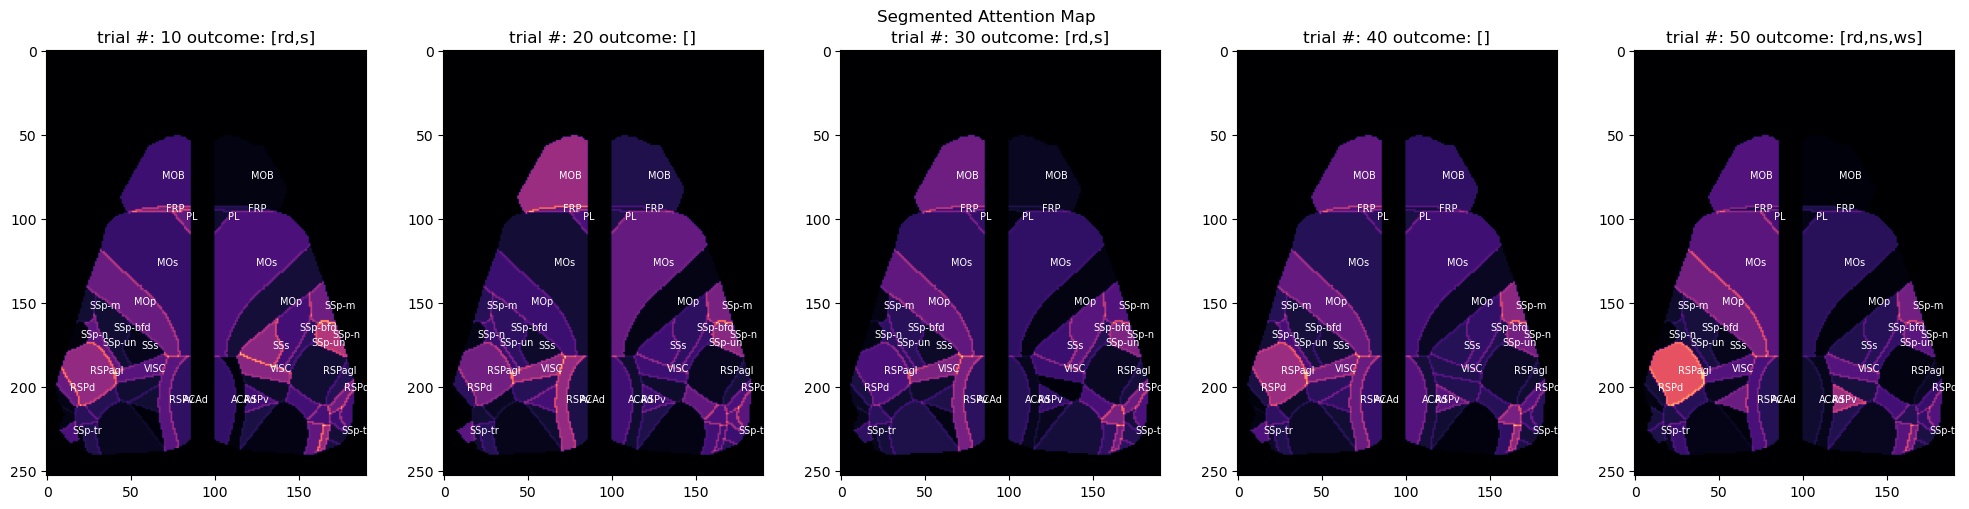

In [155]:
vid_index = [10,20,30,40,50,60]
# make 5 subplots then plot 5 different videos
fig, axs = plt.subplots(1, 5, figsize=(20, 5))
for i, ax in enumerate(axs):
    emb, attn = model_rec(brain_data[288 * vid_index[i]: (288 * int(vid_index[i] + 1))].unsqueeze(1).swapdims(1, 2).to('cuda'))
    attention_mapping = np.array([rollout(map.to('cpu'), fusion='max', dropout=0.99) for map in attn])
    attention_map = np.sum(masks * np.expand_dims(attention_mapping, [2,3]), axis=1)
    normalized_map = (np.mean(attention_map, axis=0) / (np.mean(attention_map))) * 255
    ax.imshow(normalized_map, cmap='magma')
    names = mask_df['acronym']
    centers = mask_df['left_center'].apply(ast.literal_eval)
    ## remove none values
    names = [x for x in names if x is not None]
    centers = [x for x in centers if x[0] is not None]
    ## add an axis title for each video
    ax.set_title('trial #: ' + str(vid_index[i]) + ' outcome: ' + outcomes[vid_index[i]])
    ## iterate through all names and centers and plot labels on top of image
    for i in range(len(names)//2):
        ax.text(centers[i][0], centers[i][1], names[i], color='white', fontsize=7)
        ax.text(190 - centers[i][0], centers[i][1], names[i], color='white', fontsize=7)
fig.suptitle('Segmented Attention Map')
fig.tight_layout()
plt.show()

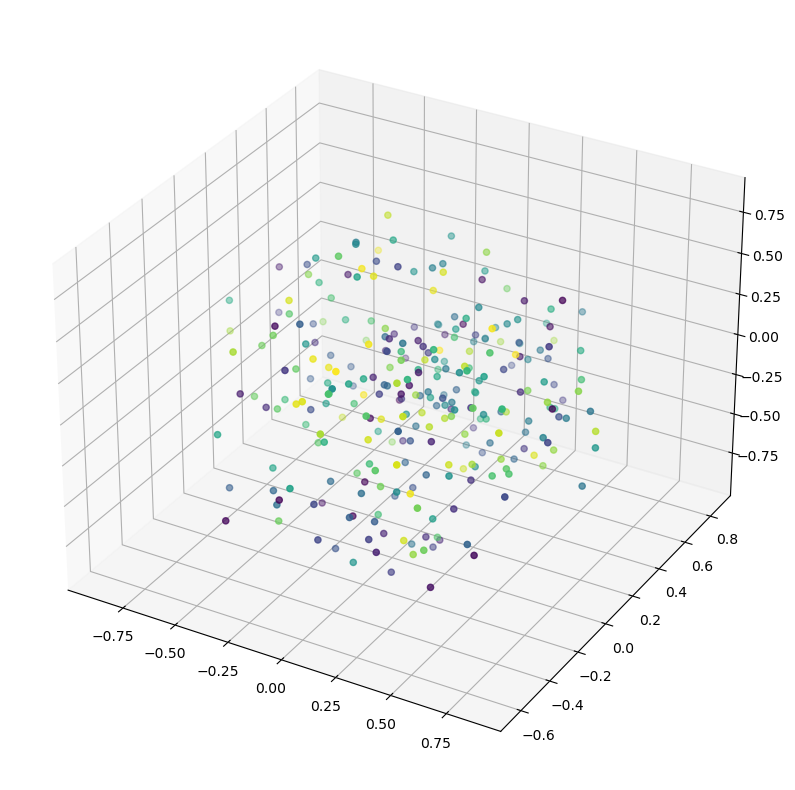

In [147]:
## plot the embeddings on a 3d graph
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10,10))
emb_det = emb.detach().cpu().numpy()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(emb_det [:,0], emb_det [:,1], emb_det [:,2], c=np.arange(288), cmap='viridis')
plt.show()